<a href="https://colab.research.google.com/github/ayush-96/msc-data-science/blob/master/deep_learning/Lab2_Deep_Learning_MSc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Experiments with basic MLP networks  and visualising the results


In [5]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfu

## Read through all the cells that you are running to ensure you mostly understand what the code is doing ! 🙂
## (Not just run cells without looking at them!)
## (Modify things ... suggestions in the code ... look up documentation ... print out values ... to understand the code.)

Run the following cell to:

*   import relevant packages
*   setup appropriate matplotlib defaults

Make sure you read through this and understand what this is doing.


In [1]:
#@title
from google.colab import files

# Common imports
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# Understanding simple networks

Let's try running some simple multi-layer perceptrons and see how they perform some basic regression and classification tasks. The goal here is to give you some insight into how a network represents the function or classifier, and what the impact of changing the parameters is.

Please do experiment with these models and try to work out how they work (a lot of it should look similar to what you did in the 60 minute PyTorch Blitz tutorial).


# Task 1 - Regression

We can start with a one dimensional regression task. A target system is $$ y = -\sin(10\pi (x+0.5)\sin(x^3))+\epsilon, $$where $\epsilon \sim \cal{N}(\mu, \sigma)$, and $\mu=0, \sigma=0.1$.



## Examine the following code.

Make sure you understand how this code is working (line by line).

What are `xgrid`, `ytrue` being used for in this code?

What are `x`, `obserr` and `y` in the code?

What might you expect `xtest` and `ytest` are used for?


Text(0, 0.5, '$y$')

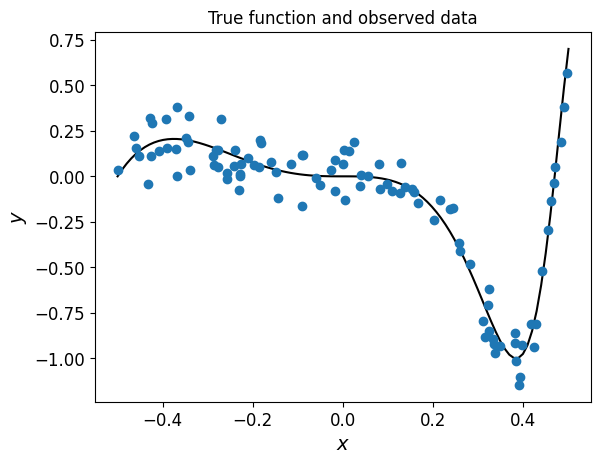

In [2]:
import math

def testfunc(x):
    # You might want to try this alternative function to experiment.
    #y = np.sin((4*math.pi*x**2))
    y = -np.sin((10*math.pi*(x+0.5)*np.sin((x)**3)))
    return y

xgrid = torch.t(torch.linspace(-0.5,0.5,100)).unsqueeze(1)
ytrue = testfunc(xgrid) # clean data from underlying function (not available for learning)

# now create some training data
N = 100         # number of noisy training observations made
noiseSigma = 0.1   # standard deviation of noise
noiseMean = 0.0    # mean of noise

x = torch.rand_like(torch.ones(N,1))-0.5
obserr = torch.randn(N,1)*noiseSigma + noiseMean
y = testfunc(x)+obserr

xtest  = torch.rand_like(torch.ones(N,1))-0.5
obserr = torch.randn(N,1)*noiseSigma + noiseMean
ytest  = testfunc(xtest)+obserr

fig = plt.figure()
plt.plot(xgrid, ytrue,'-k')
plt.plot(x,y,'o')
plt.title('True function and observed data')
plt.xlabel('$x$')
plt.ylabel('$y$')

# Train a simple "fully connected" multi-layer perceptron (MLP) network to model this data.

Make sure you understand how this code is working - ask questions !

How many layers does this network have? How many neurons in the layers? Can you extend the number of layers? How many connections between the different layers? (See the output from the code ...)

Do you get an improvement of the loss over time? (Epochs of training)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Nhidden = 10    # Try increasing the number of units
lr = 0.01
epochs = 30000

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # An affine operation: y = Wx + b
        self.fc1 = nn.Linear(1, Nhidden)  # See https://pytorch.org/docs/stable/nn.html#linear for documentation

        # See later in the notebook why you might want to do this !
        # self.fc1a = nn.Linear(Nhidden, Nhidden)
        self.fc2 = nn.Linear(Nhidden, 1)  # Can you find out how the weights are initialised? Look in the PyTorch source code https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py

    def forward(self, x):
        x = F.relu(self.fc1(x))  # try changing this to tanh() or sigmoid()

        # See later in the notebook why you might want to do this !
        # x = F.tanh(self.fc1a(x))
        x = self.fc2(x)
        return x

# 2 hidden layer
# Input layer to first hidden layer
# self.fc1 = nn.Linear(1, Nhidden1)

# First hidden layer to second hidden layer
# self.fc2 = nn.Linear(Nhidden1, Nhidden2)

# Second hidden layer to output layer
# self.fc3 = nn.Linear(Nhidden2, 1)

net = Net()
print(net)

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)


for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0

print('Finished Training')



Net(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)
[2000,     1] loss: 0.086
[4000,     1] loss: 0.086
[6000,     1] loss: 0.086
[8000,     1] loss: 0.086
[10000,     1] loss: 0.086
[12000,     1] loss: 0.085
[14000,     1] loss: 0.085
[16000,     1] loss: 0.085
[18000,     1] loss: 0.085
[20000,     1] loss: 0.085
[22000,     1] loss: 0.085
[24000,     1] loss: 0.085
[26000,     1] loss: 0.085
[28000,     1] loss: 0.085
[30000,     1] loss: 0.085
Finished Training


# Use the model to do predictions!

Does it work as well as you would hope?

How about if you add in the extra layer into the network? (Need to go back and update the model.) How has it changed the "architecture" of the network in terms of layers, number of neurons in those layers and number of connections between the layers? How has this changed the loss over epochs ? How has it changed the fit given below ?

Text(0.5, 1.0, 'Regression comparison')

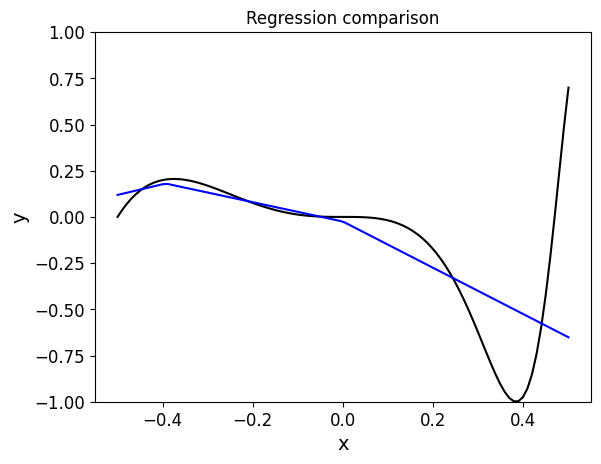

In [5]:
pred_y = net(x)
pred_ygrid = net(xgrid)

plt.figure()
plt.plot(xgrid, ytrue,'k-')
plt.plot(xgrid, pred_ygrid.detach().numpy(),'b-')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim([-1, 1])
plt.title('Regression comparison')

You can view the parameter values of the layers as a list of numpy arrays using the .weight command in pyTorch. Each layer can be accessed independently.

Do the number of weights and bias terms printed make sense here given the structure of this network ?




In [6]:
print('First hidden layer weights', torch.t(net.fc1.weight)) # first hidden layer weights (transposed for ease of inspection)
print('First hidden layer biases', net.fc1.bias) # first hidden layer biases
print('Second layer weights',net.fc2.weight) # second layer
print('Second layer bias', net.fc2.bias) # second layer

First hidden layer weights tensor([[ 0.9738, -0.6984, -0.3411, -0.4536, -0.4403, -0.8377, -1.1367, -0.5246,
         -0.7452, -0.3723]], grad_fn=<TBackward0>)
First hidden layer biases Parameter containing:
tensor([ 2.4045e-04, -3.4836e-01,  6.4518e-01, -1.7844e-01, -2.9610e-01,
         6.4742e-01, -4.4722e-01, -7.3889e-01, -9.9672e-01, -7.2489e-01],
       requires_grad=True)
Second layer weights Parameter containing:
tensor([[-0.7486,  0.0981,  0.0901, -0.3546, -0.1629,  0.5878, -0.8283, -0.2542,
          0.2076, -0.0490]], requires_grad=True)
Second layer bias Parameter containing:
tensor([-0.4638], requires_grad=True)


# Do further experimentation on this regression problem to improve it ...

Experiment (possibly changing one thing at a time for comparison) with:

1. The amount of training data (try 100, 200, 1000 points), and noise levels on the data (try 0.01 and 0.1 for noiseSigma).
2. The number of units (neurons) in the model (essentially the "width" of the network).
3. The choice of activation function.
4. Add an extra layer of hidden units to the network and compare performance between two layers of N units and one layer of 2N units (essentially the "depth" of the network).

Compare these by plotting a visualisation of the network output at `xgrid` inputs, and compare it with the `ytrue` results.





---



# Task 2 - Classification

Now we will try out some experiments with simple two-dimensional classification tasks. Again read through the code to make sure you feel you understand how it is working. For instance, how does meshgrid() work? Look it up in the PyTorch documentation if you are not sure what it is doing. See if you can work out the shape (or size) of the tensors involved (can always print out value.shape to checkthis !) For instance, what shape does `x` have in this code ?


**Dataset 1**


176


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0, 0.5, '$x_2$')

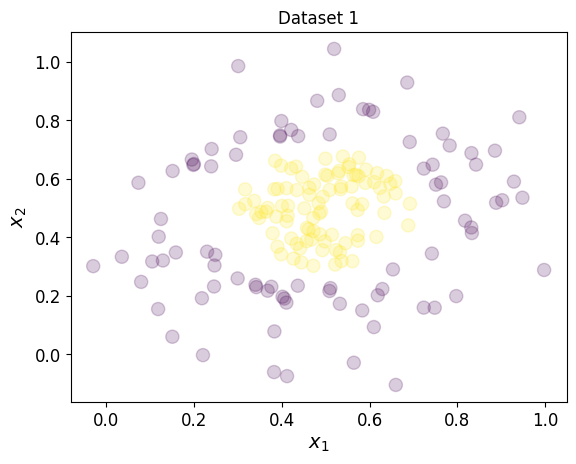

In [7]:
N = 200

xgrid = torch.arange(0,1.0,0.01)

X,Y = torch.meshgrid(xgrid, xgrid)
testgrid = torch.zeros((np.shape(xgrid)[0]**2,2))
testgrid[:,0] = X.flatten()
testgrid[:,1] = Y.flatten()


# What distribution is produced by torch.randn ?
# Try experimenting with different types of input distribution
# x = np.random.uniform(low = 0.0, high = 1.0, size= (N,2))

x = 0.2*torch.randn(N,2)+torch.tensor([0.5, 0.5])

y = ((torch.linalg.vector_norm(x-0.5, dim=1) < 0.2)*1.0).type(torch.float)  # make the class be a circle in the centre of the scene.

# cut out a border around the classes to make the task a bit more realistic
ind_incl = (torch.linalg.vector_norm(x-0.5, dim=1) > 0.25) | (torch.linalg.vector_norm(x-0.5, dim=1) < 0.20)
x = x[ind_incl,:]
y = y[ind_incl]
N = y.shape[0]
y = y.reshape(N,1)
print(N)

Ntest = 1000
xtest = 0.2*torch.randn(Ntest,2)+torch.tensor([0.5, 0.5])
ytest = ((torch.linalg.vector_norm(xtest-0.5, dim=1) < 0.2)*1.0).type(torch.float)

# cut out a border around the classes to make the task a bit more realistic
ind_incl = (torch.norm(xtest-0.5, dim=1) > 0.25) | (torch.norm(xtest-0.5, dim=1) < 0.20)
xtest = xtest[ind_incl,:]
ytest = ytest[ind_incl]

Ntest = ytest.shape[0]
ytest = ytest.reshape(Ntest,1)

plt.figure()
plt.scatter(x[:,0].numpy(),x[:,1].numpy(), alpha=0.2, s=90, cmap='viridis', c=y.view(-1))
plt.title('Dataset 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

---

# Define a suitable MLP or "fully-connected" model

This type of simple network can alternatively be created using the nn.Sequential container. See this [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) class page in the PyTorch documentation for an example of this.


What is the size of the input to this model? What is the size of output? Why do we have a sigmoid activation function on the output? (See the printed output.)



In [8]:
Nhidden = 10
lamb=0.0000    # L2 weight decay term
lr = 0.01
epochs = 20000


class Net2d(nn.Module):
    def __init__(self):
        super(Net2d, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, Nhidden)
        self.fc2 = nn.Linear(Nhidden, Nhidden)
        self.fc3 = nn.Linear(Nhidden, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

net2d = Net2d()
print(net2d)



Net2d(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


# Training the network

What type of loss are we using here? Why are we not using MSELoss ?

In [9]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net2d.parameters(), lr=lr, momentum=0.9, weight_decay=lamb) # Note that this is adding L2 regularisation with factor lamb to every parameter

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net2d(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0


[2000,     1] loss: 0.062
[4000,     1] loss: 0.012
[6000,     1] loss: 0.006
[8000,     1] loss: 0.004
[10000,     1] loss: 0.003
[12000,     1] loss: 0.002
[14000,     1] loss: 0.002
[16000,     1] loss: 0.001
[18000,     1] loss: 0.001
[20000,     1] loss: 0.001


# Using the network to do prediction

Final training set loss  0.0010297899134457111
Test loss  0.017825745046138763
Percentage correct  99.41657257080078


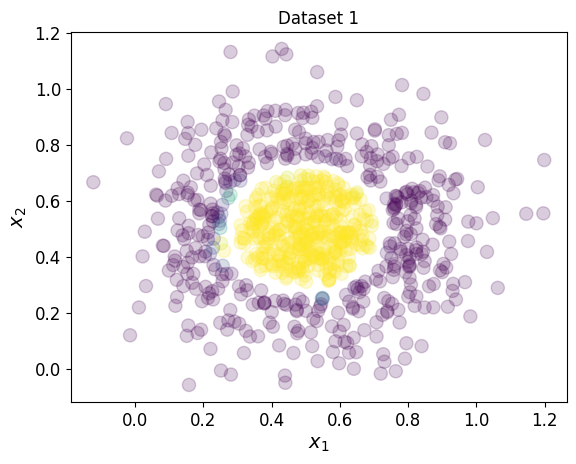

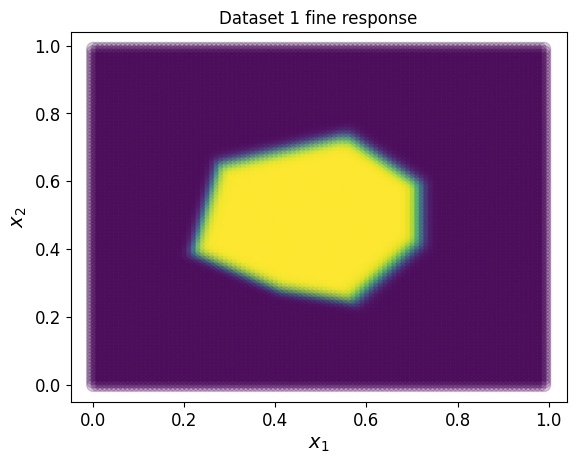

In [10]:
pred_test = net2d(xtest)
plt.figure()
plt.scatter(xtest[:,0],xtest[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_test[:,0].detach().numpy())
plt.title('Dataset 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

pred_testgrid = net2d(testgrid)
plt.figure()
plt.scatter(testgrid[:,0],testgrid[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_testgrid[:,0].detach().numpy())
plt.title('Dataset 1 fine response')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

print('Final training set loss ', criterion(outputs, y).item())
test_loss = criterion(pred_test, ytest)
print('Test loss ', test_loss.item())
classification = torch.round(pred_test)
percentage = 100*sum(ytest.type(torch.int) == classification.type(torch.int))/Ntest
print('Percentage correct ', percentage.item())

# Experiment with the following ...

Try repeating these experiments with the following variations:
- Try with 200, 500, 2000 training points. How does that change the response of the function?
- Try changing the number of hidden units. What changes?
    - Do you see as many 'edges' on the decision boundary when using ReLUs as units? Why do you think this is?
    - Try with 1,2,3 hidden layers.
- Try with Sigmoids in the hidden layer rather than ReLUs.
    - How does that change the shape of the decision boundary? Why do you think this is?
    - How does it change the speed of error reduction?

- Try changing the loss function from Binary Cross-Entropy (`BCEloss`) to `MSEloss`. How does that affect performance? How does it affect perfomance in `mse`?
- During the above you may find that some configurations take a lot longer to reduce the error than others.


The correct choice of loss function is linked to the output type, as shown in the table below:

![output/cost function table](https://docs.google.com/uc?export=download&id=1Z2C-NJh35shzvtMlvEtDpyQgGM10bvew)







---



# Task 3 - Classification


Let's do a classification based on the boundary that we used for regression !

---

**Dataset 2**

Text(0, 0.5, '$x_2$')

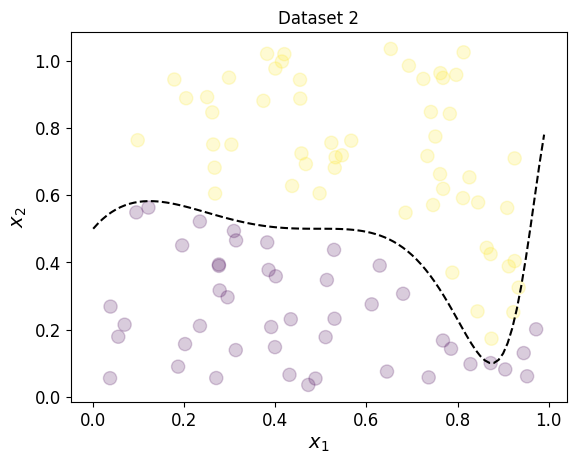

In [11]:
N = 100   # Try 100, 500, 1000

xgrid1 = torch.arange(0,1.0,0.01)

#try experimenting with different types of input distribution
data_dist = 1 # 1 - uniform 0.5-0.5, 2 - normally distributed

if data_dist == 1:
   x = torch.rand(N,2)
else:
   x = 0.15*torch.randn(N,2)+torch.tensor([0.5, 0.5])
ind_pos = (0.5+0.4*testfunc(x[:,0]-0.5)<x[:,1])
y = (ind_pos*1.0).type(torch.float)  # lets create a classification line based on old regression function
N = y.shape[0]
y = y.reshape(N,1)
x[ind_pos,1] = x[ind_pos,1]+0.05 # create a gap between classes.


if data_dist == 1:
  xtest = torch.rand(N,2)
else:
  xtest = 0.15*torch.randn(N,2)+torch.tensor([0.5, 0.5])
ind_post = (0.5+0.4*testfunc(xtest[:,0]-0.5)<xtest[:,1])
ytest = (ind_post*1.0).type(torch.float)  # let's create a classification line based on old regression function
Ntest = ytest.shape[0]
ytest = ytest.reshape(Ntest,1)
xtest[ind_post,1] = xtest[ind_post,1]+0.05 # create a gap between classes.


plt.figure()
plt.scatter(x[:,0],x[:,1], alpha=0.2, s=90, cmap='viridis', c=y.view(-1))
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for this problem
plt.title('Dataset 2')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')



# Define the model

This time we will use the Sequential container that was mentioned above to define this model.

In [12]:
Nhidden = 10 # experiment with this
lamb=0.00
lr = 0.01
epochs = 50000


net2d = nn.Sequential(nn.Linear(2,Nhidden),
                      nn.ReLU(),
                      nn.Linear(Nhidden, Nhidden),
                      nn.ReLU(),
                      nn.Linear(Nhidden, 1),
                      nn.Sigmoid())
# reuse net2d variable.


# Train the model

Does the loss change during training? What is this telling you?

In [13]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net2d.parameters(), lr=lr, momentum=0.9, weight_decay=lamb) # Note that this is adding L2 regularisation with factor lamb to every parameter

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net2d(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0

[2000,     1] loss: 0.073
[4000,     1] loss: 0.073
[6000,     1] loss: 0.073
[8000,     1] loss: 0.073
[10000,     1] loss: 0.073
[12000,     1] loss: 0.073
[14000,     1] loss: 0.073
[16000,     1] loss: 0.073
[18000,     1] loss: 0.073
[20000,     1] loss: 0.073
[22000,     1] loss: 0.073
[24000,     1] loss: 0.073
[26000,     1] loss: 0.073
[28000,     1] loss: 0.073
[30000,     1] loss: 0.073
[32000,     1] loss: 0.073
[34000,     1] loss: 0.073
[36000,     1] loss: 0.073
[38000,     1] loss: 0.073
[40000,     1] loss: 0.073
[42000,     1] loss: 0.073
[44000,     1] loss: 0.073
[46000,     1] loss: 0.073
[48000,     1] loss: 0.073
[50000,     1] loss: 0.073


# Do prediction on the test set using the model

Final training set loss  0.07278046756982803
Test loss  0.19993168115615845
Percentage correct  97.0


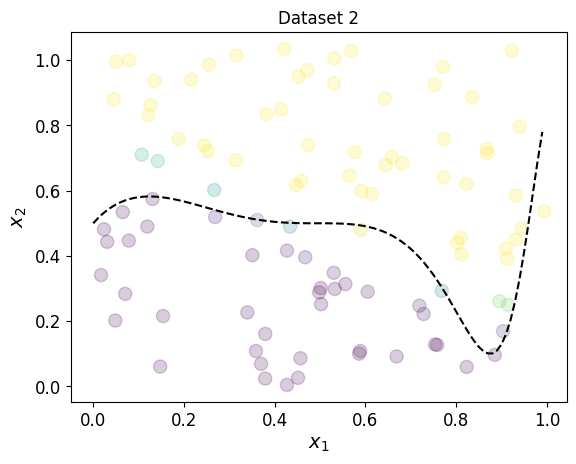

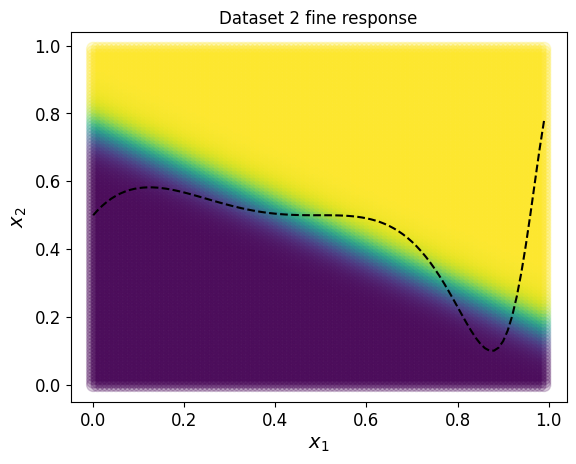

In [14]:
pred_test = net2d(xtest)
plt.figure()
plt.scatter(xtest[:,0],xtest[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_test[:,0].detach().numpy())
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for dataset2 problem
plt.title('Dataset 2')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

pred_testgrid = net2d(testgrid)
plt.figure()
plt.scatter(testgrid[:,0],testgrid[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_testgrid[:,0].detach().numpy())
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for this problem
plt.title('Dataset 2 fine response')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

print('Final training set loss ', criterion(outputs, y).item())
test_loss = criterion(pred_test, ytest)
print('Test loss ', test_loss.item())
classification = torch.round(pred_test)
percentage = 100.0*torch.sum(ytest.type(torch.int) == classification.type(torch.int))/Ntest
print('Percentage correct ', percentage.item())

# Try experimenting with the following aspects of this network:

Try changing the distribution of the training data (e.g. make it normally distributed) but keeping the same classification boundary. How does that change the resulting classification boundary?

Try with N= 100, 500, 1000 training examples with linearly distribute and normally distributed data. What is this telling you?

Try different sizes of network to see what differences result.

What happens with small training sets and large networks?